In [1]:
import os
os.environ['OMP_NUM_THREADS']='3'

from dolfin import Constant, Expression, inner, interpolate, assemble, Function, norm, plot
from dolfin import PETScKrylovSolver, PETScLUSolver, LUSolver
from dolfin.common.plotting import mplot_function

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator

import sys
sys.path.insert(0, '../../')
from reaktoro_transport.problem import DarcyFlowMixedPoisson, DarcyFlowUzawa
from reaktoro_transport.mesh import MarkedRectangleMesh

In [2]:
# Load 2D matrix 
aperture_field = np.load('/home/powei/Downloads/matchedarray100.npy')

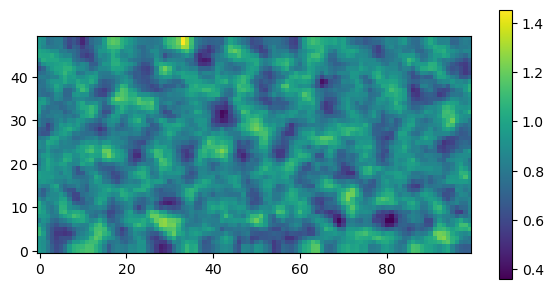

In [3]:
plt.figure(figsize=(7,3.5))
plt.imshow(aperture_field, origin='lower')
plt.colorbar()
plt.show()

In [4]:
ny, nx = np.shape(aperture_field)

In [5]:
class LocalCubicLawFlow(DarcyFlowUzawa, MarkedRectangleMesh):
    def __init__(self, nx, ny):
        #mesh_factory = MarkedRectangleMesh()
        
        self.set_bottom_left_coordinates(coord_x = 0.0, coord_y = 0.0)
        self.set_top_right_coordinates(coord_x = 2.0, coord_y = 1.0)
        self.set_number_of_elements(num_elements_x = nx, num_elements_y = ny)
        self.set_mesh_type('triangle')
        
        mesh = self.generate_mesh()
        boundary_markers, self.marker_dict = self.generate_boundary_markers()
        domain_markers = self.generate_domain_markers()
        
        super().__init__(mesh, boundary_markers, domain_markers)
    
    def get_marker_dict(self):
        return self.marker_dict
    
    def set_permeability_from_image(self, aperture_field):
        
        ny, nx = np.shape(aperture_field)
        
        shape_factor = 12.0
        apertureT = np.flip(np.rot90(aperture_field), axis=0)
        x_space = np.linspace(self.xmin, self.xmax, nx)
        y_space = np.linspace(self.ymin, self.ymax, ny)

        aperture_interpolator = RegularGridInterpolator((x_space, y_space), 
                                                        apertureT, 'linear', bounds_error=True)
        
        dof_coord = self.pressure_func_space.tabulate_dof_coordinates()

        dof_x = dof_coord[:, 0]
        dof_y = dof_coord[:, 1]
        
        self._k = Function(self.pressure_func_space)
        self._phi = Function(self.pressure_func_space)

        for i in range(len(dof_x)):
            aperture_size = aperture_interpolator([dof_x[i], dof_y[i]])
            self._k.vector()[i] = aperture_size**2/shape_factor
            self._phi.vector()[i] = aperture_size
        
    
    def get_average_permeability(self, marker: int):
        
        aperture_size = 1.0
        flow_rate = assemble(inner(self.fluid_velocity, self.n)*self.ds(marker))
        cross_section_area = assemble(self._phi*self.ds(marker))*aperture_size
        sample_length = 1.0
        delta_p = 1.0
        viscosity = self._mu.values()[0]
        
        permeability = flow_rate*viscosity*sample_length/(cross_section_area*delta_p)
        
        return permeability
    
    def set_solver(self):
        # Users can override this method.
        # Or, TODO: make this method more user friendly.

        self.solver_v = PETScLUSolver('petsc')
        self.solver_p = PETScKrylovSolver('gmres', 'amg')

        prm_v = self.solver_v.parameters
        prm_p = self.solver_p.parameters

        #super().set_default_solver_parameters(prm_v)
        super().set_default_solver_parameters(prm_p)
    
problem = LocalCubicLawFlow(nx, ny)
marker_dict = problem.get_marker_dict()

In [6]:
problem.mark_flow_boundary(pressure = [marker_dict['top'], marker_dict['bottom']],
                           velocity = [marker_dict['left'], marker_dict['right']])

problem.set_pressure_fe_space('DG', 0)
problem.set_velocity_fe_space('RT', 1)

problem.set_permeability_from_image(aperture_field)

In [7]:
problem.set_pressure_ic(Constant(0.0))

problem.set_fluid_density(1.0)
problem.set_fluid_viscosity(1.0)
problem.set_gravity((0.0, 0.0))

problem.set_pressure_bc([Constant(0.0), Constant(1.0)])
problem.generate_form()
problem.set_velocity_bc([Constant((0.0, 0.0))]*2)

problem.set_solver()
problem.assemble_matrix()

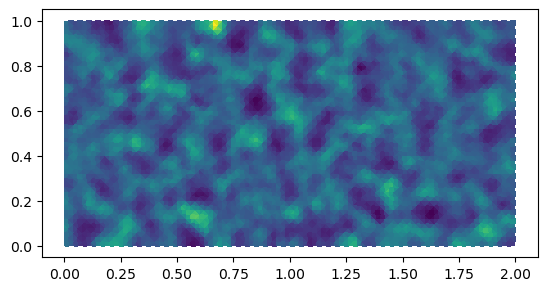

In [8]:
plt.figure()
plot(problem.get_permeability())
plt.show()

In [9]:
%%time
problem.solve_flow(target_error=1e-5, max_steps=10)

CPU times: user 530 ms, sys: 8.27 ms, total: 538 ms
Wall time: 540 ms


In [10]:
problem.generate_residual_form()
problem.get_residual()

8.313232017732189e-05

In [11]:
velocity = problem.get_fluid_velocity()
pressure = problem.get_fluid_pressure()

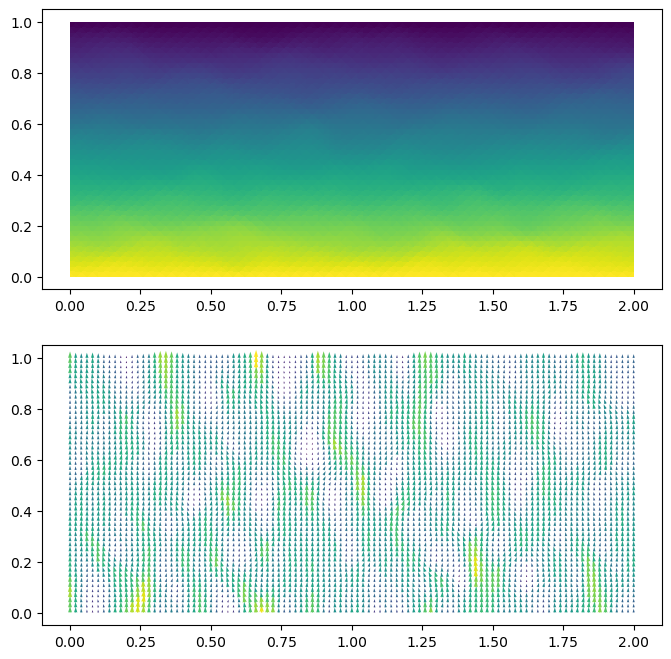

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(8,8))

mplot_function(ax[0], pressure)
mplot_function(ax[1], velocity)

plt.show()

In [13]:
problem.quick_save(file_name='pv_output')

In [14]:
problem.get_average_permeability(marker=marker_dict['top'])

0.06710040354474626